 Mean Field VI for GMM assuming all model parameters are random

In [507]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi
from scipy.special import digamma 

from scipy.special import gammaln, psi
from numpy.linalg import slogdet, inv


In [508]:
random_seed = 123
rng = np.random.default_rng(random_seed)

We want to compute the intractable GMM posterior:
$$
    p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}|\mathbf{X}) = \frac{p(\mathbf{X},\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z},\boldsymbol{\pi})}{p(\mathbf{X})}
$$

Introduce approximating distribution $q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})$ where we use KL divergence as a cost function 
$$
    \mathbb{KL}(q||p) = \sum_{\mathbf{z},\boldsymbol{\mu}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}|\mathbf{X})}
$$

Objective : 
$$\begin{align}
    \mathcal{J}(q) &= \mathbb{KL}(q||p) = \int\int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\pi})\log\frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}{p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}|\mathbf{X})}d\boldsymbol{\mu}d\boldsymbol{\pi} d\boldsymbol{\Sigma}\\\\

    &=  \int\int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})\log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})d\boldsymbol{\mu}d\boldsymbol{\Sigma}d\boldsymbol{\pi} - \int\int\int\sum_{\mathbf{z}}q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})\log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}|\mathbf{X})d\boldsymbol{\mu}d\boldsymbol{\pi}d\boldsymbol{\Sigma}\\\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})} - \Big\langle \log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}|\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}\\

    &= \Big\langle \log q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z}, 
       \boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})} -
       \Big\langle \log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi},\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})} + 
       \Big\langle  \log p(\mathbf{X}) \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}\\\\

    &= \Big\langle  \log \frac{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}{p(\mathbf{X})} \Big\rangle_{q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})}  + 
       \log p(\mathbf{X}) \\\\
    
    &= \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi},\mathbf{X})\Big) + \underbrace{\log p(\mathbf{X})}_{\text{constant}}
\end{align}$$

Objective can simplify to
$$\begin{align}
    q* &\leftarrow \argmin_{q} \left[  \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi},\mathbf{X})\Big)  + \underbrace{\log p(\mathbf{X})}_{\text{constant}} \right]\\
        &= \argmin_{q} \left[ \mathbb{KL}\Big(q(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) || p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi},\mathbf{X})\Big) \right]
\end{align}$$

---

## Mean Field 

Mean Field (Structured) Independence Simplifying Assumption
$$
    q(\boldsymbol{\pi},\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z}) = 
        \underbrace{q(\boldsymbol{\pi})}_{\text{Dirichlet}}
        \underbrace{q(\boldsymbol{\mu},\boldsymbol{\Sigma})}_{\text{NIW}}
        \underbrace{q(\mathbf{z})}_{\text{Cat}}
$$

Update Steps 

$$\begin{align}
    &\log q(\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) = \Big\langle \log p(\mathbf{z},\mu,\Sigma,\mathbf{X}) \Big\rangle_{q(\mathbf{z})}  + \text{const}\\\\
    
    &\log q(\mathbf{z}) = \Big\langle \log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{X}) \Big\rangle_{q(\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})} + \text{const}
\end{align}$$

Posterior
$$
    p(\mathbf{X},\boldsymbol{\mu},\mathbf{z},\boldsymbol{\pi},\boldsymbol{\Sigma}) \propto p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z})p(\boldsymbol{\mu}|\boldsymbol{\Sigma})p(\boldsymbol{\Sigma})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$

### Updates for variational posterior of model parameters $q(\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi}) &= \Big\langle \log p(\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{X}) \Big\rangle_{q(\mathbf{z})}  + \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma}) \Big\rangle_{q(\mathbf{z})} 
       + \Big\langle \log p(\boldsymbol{\mu}|\boldsymbol{\Sigma})p(\boldsymbol{\Sigma})\Big\rangle_{q(\mathbf{z})} 
       + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} 
       + \text{const}\\\\

    &= \underbrace{\log p(\boldsymbol{\Sigma}) + \log p(\boldsymbol{\mu}|\boldsymbol{\Sigma}) 
       + \Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma})}_{\text{Terms containing $\mu,\Sigma$}} \Big\rangle_{q(\mathbf{z})}
       + \underbrace{\Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \log p(\boldsymbol{\pi})}_{\text{Terms containing $\pi$}}
\end{align}$$

Can separate RHS into terms containing $\pi$ and $\mu$

#### Update Step for $q(\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \Big\langle \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \Big\langle \sum_n^N \sum_k^K \log \pi_{k}^{z_{nk}} \Big\rangle_{q(\mathbf{z})} + \text{const} \\
       
    &= \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} +
       \Big\langle \sum_k^K \sum_n^N z_{nk}\log \pi_{k} \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \log \pi_{k} + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &= \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\

\end{align}$$

#### Update step for $q(\boldsymbol{\mu},\boldsymbol{\Sigma})$

$$\begin{align}
    \log q(\boldsymbol{\mu},\boldsymbol{\Sigma}) &= \log p(\boldsymbol{\Sigma}) + \log p(\boldsymbol{\mu}|\boldsymbol{\Sigma}) + \Big\langle \log p(\mathbf{X}|\mathbf{z},\boldsymbol{\mu},\boldsymbol{\Sigma})\Big\rangle_{q(\mathbf{z})} + \text{const}\\

    &= \sum_k^K \log p(\boldsymbol{\Sigma}) + \sum_k^K \log p(\boldsymbol{\mu}|\boldsymbol{\Sigma}) + \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}}\Big\rangle_{q(\mathbf{z})} + \text{const}\\

    &= \sum_k^K \Big[ 
            \log p(\boldsymbol{\Sigma}_k) + \log p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k) 
            + \Big\langle \sum_n^N z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \Big\rangle_{q(\mathbf{z})}
        \Big] + \text{const}\\

    &= \sum_k^K \Big[ 
            \log p(\boldsymbol{\Sigma}_k) + \log p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k) 
            +  \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) 
        \Big] + \text{const}\\

    &= \sum_k^K \Big[ 
            \log p(\boldsymbol{\Sigma}_k) + \log p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k) 
            +  \sum_n^N r_{nk} \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) 
        \Big] + \text{const}\\   
        
    \implies & \log q(\boldsymbol{\mu},\boldsymbol{\Sigma}) = \sum_k^K q(\mu_k, \Sigma_k)
\end{align}$$
Hence, 

$$\begin{align}
    \log q(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) &= \underbrace{\log p(\boldsymbol{\Sigma}_k) + \log p(\boldsymbol{\mu}_k|\boldsymbol{\Sigma}_k)}_{\text{NIW}} +  \sum_n^N r_{nk} \log \underbrace{p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)}_{\text{MVN}} + \text{const}\\

    &= \log \text{NIW}(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k | \mathbf{m}_{0,k},\kappa_{0,k},\nu_{0,k},\mathbf{S}_{0,k}) + 
       \sum_n^N r_{nk} \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) + \text{const}\\

    &= \log \Big[ \mathcal{N}(\boldsymbol{\mu}_k|\mathbf{m}_{0,k},\frac{1}{\kappa_{0,k}}\boldsymbol{\Sigma}_k) \cdot \mathcal{IW}(\boldsymbol{\Sigma}_k|\nu_{0,k},\mathbf{S}_{0,k}) \Big] + 
    \sum_n^N r_{nk} \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) + \text{const}\\\\

    &= \log\underbrace{\big(|\boldsymbol{\Sigma}_k|^{-\frac{\nu_0 + D + 1}{2}}\big) + \Big( -\frac{\kappa_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k}) \Big)}_{\text{Terms dependent on $\mu_k,\Sigma_k$}}\\
       &\qquad\qquad + \sum_n^N r_{nk} \big(\underbrace{-\frac{1}{2}\log|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\mu_k,\Sigma_k$}}\big) + \text{const}\\\\

    &= \log\big(|\boldsymbol{\Sigma}_k|^{-\frac{\nu_0 + D + 1}{2}}\big) + \Big( -\frac{\kappa_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k}) \Big)\\
       &\qquad\qquad + \sum_n^N r_{nk} \big(-\frac{1}{2}\log|\boldsymbol{\Sigma}_k|\big) + \sum_n^N r_{nk} \big( -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)\big) + \text{const}\\\\

    &= \log\big(|\boldsymbol{\Sigma}_k|^{-\frac{\nu_0 + D + 1}{2}}\big) + \Big( -\frac{\kappa_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k}) \Big)\\
       &\qquad\qquad + \sum_n^N  -\frac{r_{nk}}{2}\log|\boldsymbol{\Sigma}_k| + \sum_n^N r_{nk} \big( -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)\big) + \text{const}\\\\
    

    &= \left(-\frac{\nu_0 + D + 1}{2}\right)\log\big|\boldsymbol{\Sigma}_k\big| + \Big( -\frac{\kappa_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k}) \Big)\\
       &\qquad\qquad + \log|\boldsymbol{\Sigma}_k | \sum_n^N  -\frac{r_{nk}}{2} + \sum_n^N r_{nk} \big(-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)\big) + \text{const}\\\\

    &= \left(-\frac{\nu_0 + D + 1}{2}\right)\log\big|\boldsymbol{\Sigma}_k\big| +
        \Big( -\frac{\kappa_0}{2} (\boldsymbol{\mu}_k - \mathbf{m}_{0,k})^T \boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{m}_{0,k}) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k}) \Big)\\
            &\qquad\qquad \log|\boldsymbol{\Sigma}_k|^{\frac{-N_k}{2}}- \frac{1}{2}\Big[\text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{\mathbf{x}}_k}) + N_k(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\bar{\mathbf{x}}_k - \boldsymbol{\mu}_k)\Big] + \text{const}, \\
            &\qquad\qquad \text{where } N_k = \sum_n^N r_{nk}, \quad  \bar{\mathbf{x}}_k = \frac{1}{N_k} \sum_n^N r_{nk}\cdot\mathbf{x}_n,\quad \mathbf{S}_{\bar{\mathbf{x}}_k} = \sum_n^N r_{nk}(\mathbf{x}_n - \bar{\mathbf{x}}_k)(\mathbf{x}_n - \bar{\mathbf{x}}_k)^T\\\\

    &= \left(-\frac{\nu_0 + N_k + D + 1}{2}\right)\log\big|\boldsymbol{\Sigma}_k\big| + 
       \Big[  -\frac{\kappa_0}{2} \big( \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} \big) -\frac{1}{2} \text{tr}(\boldsymbol{\Sigma}^{-1}\mathbf{S}_{0,k}) \Big]\\

        &\qquad - \frac{1}{2}\Big[\text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{\mathbf{x}}_k}) + N_k\big(\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k - 2\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\big)\Big] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| + 
              \kappa_0 \big( \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + \mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} \big) + \text{tr}(\boldsymbol{\Sigma}^{-1}\mathbf{S}_{0,k}) \\

            &\qquad + \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{\mathbf{x}}_k}) + N_k\big(\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k - 2\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\big)
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| +
                \text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{0,k} + \boldsymbol{\Sigma}_k^{-1}\mathbf{S}_{\bar{x}_k}) + \underbrace{\kappa_0\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k}_{(1)} - \underbrace{2\kappa_0\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k}}_{(2)} + \underbrace{\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k}}_{(3)} + \\

                &\qquad\qquad \underbrace{N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k}_{(3)} - \underbrace{2N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k}_{(2)} + \underbrace{N_k\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k}_{(1)}
        \Bigg] + \text{const}, \qquad\qquad \text{Identify like terms}

\end{align}$$

$$\begin{align}
   \qquad\qquad\qquad\qquad\qquad &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k})\Big) + \\
            
                &\qquad\qquad (\kappa_0 + N_k)\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k - 2\Big( \kappa_0\boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big) + \kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k})\Big) + \\

            &\qquad\qquad \boldsymbol{\mu}_k^T\underbrace{\Big((\kappa_0 + N_k)\boldsymbol{\Sigma}_k^{-1}\Big)}_{\mathbf{M}}\boldsymbol{\mu}_k - 2\boldsymbol{\mu}_k^T\underbrace{\Big( \kappa_0\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\mathbf{\bar{x}}_k  \Big)}_{\mathbf{b}} + \kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k})\Big) + \\

            &\qquad\qquad \underline{(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})}  - \mathbf{b}^T\mathbf{M}^{-1}\mathbf{b} + \kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k}  + N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k
        \Bigg] + \text{const},\qquad \text{Complete the square}\\
        &\text{where,}\\
            &\qquad\qquad \mathbf{M} = (\kappa_0 + N_k)\boldsymbol{\Sigma}_k^{-1}\\
            &\qquad\qquad \mathbf{b} = (\kappa_0\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\mathbf{\bar{x}}_k)\\\\

    &= -\frac{1}{2}\Bigg[
            (\cdots) -
                (\kappa_0\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\mathbf{\bar{x}}_k)^T
                \left(\frac{1}{\kappa_0 + N_k}\boldsymbol{\Sigma}_k\right)
                (\kappa_0\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\mathbf{\bar{x}}_k) + \\
            &\qquad\qquad\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
            N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\cdots) -
                \left(\frac{1}{\kappa_0 + N_k}\right)
                (\kappa_0\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + N_k\boldsymbol{\Sigma}_k^{-1}\mathbf{\bar{x}}_k)^T
                (\kappa_0\mathbf{m}_{0,k} + N_k\mathbf{\bar{x}}_k) + \\
            &\qquad\qquad\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
            N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Bigg] + \text{const}\\\\


    &= -\frac{1}{2}\Bigg[(\cdots) -
                \left(\frac{1}{\kappa_0 + N_k}\right) \Big[
                    \kappa_0^2 \mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
                    \kappa_0 N_k (
                        \kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k + 
                        \kappa_0\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k}
                    ) + 
                    N_k^2\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
                \Big] + \\
            &\qquad\qquad\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
            N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\cdots) 
                    -\frac{\kappa_0^2}{\kappa_0 + N_k}\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
                    -\frac{k_0N_k}{\kappa_0 + N_k} (
                        \kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k + 
                        \kappa_0\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k}
                    ) - 
                    \frac{N_k^2}{\kappa_0 + N_k}\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k + \\
            &\qquad\qquad\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} + 
            N_k\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\cdots) 
                    \frac{k_0N_k}{\kappa_0 + N_k} \mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} - 
                    \frac{k_0N_k}{\kappa_0 + N_k} (
                        2\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k
                    ) + 
                    \frac{k_0N_k}{\kappa_0 + N_k}\bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\cdots) + \frac{k_0N_k}{\kappa_0 + N_k} \Big(
                    \mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\mathbf{m}_{0,k} - 
                    2\kappa_0\mathbf{m}_{0,k}^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k + 
                    \bar{\mathbf{x}}_k^T\boldsymbol{\Sigma}_k^{-1}\bar{\mathbf{x}}_k 
                \Big)
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\cdots) + \frac{k_0N_k}{\kappa_0 + N_k} \Big(
                    (\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)
                \Big)
        \Bigg] + \text{const}\\\\

    &= -\frac{1}{2}\Bigg[(\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| + \text{tr}\Big(\boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k})\Big) + \\
                &\qquad\qquad \text{tr}\Big(
                    \frac{k_0N_k}{\kappa_0 + N_k} 
                    \boldsymbol{\Sigma}_k^{-1}(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T
                \Big)
        \Bigg] + \text{const},\qquad \text{Apply trace and use cyclic property}\\\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| +
             \text{tr}\Big(
                \boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k}) + 
                \frac{k_0N_k}{\kappa_0 + N_k}\boldsymbol{\Sigma}_k^{-1}(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T

             \Big) + \\

                &\qquad\qquad (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
            \Bigg] + \text{const}\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| +
             \text{tr}\Big(
                \boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k} + \frac{k_0N_k}{\kappa_0 + N_k}) 
                (\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T

             \Big) + \\

                &\qquad\qquad (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\mathbf{M}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
            \Bigg] + \text{const}\\

    &= -\frac{1}{2}\Bigg[
            (\nu_0 + N_k + D + 1)\log\big|\boldsymbol{\Sigma}_k\big| +
             \text{tr}\Big(
                \boldsymbol{\Sigma}_k^{-1}(\mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k} + \frac{k_0N_k}{\kappa_0 + N_k} 
                (\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T)
             \Big) + \\

                &\qquad\qquad (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\underline{((\kappa_0 + N_k)\boldsymbol{\Sigma}_k^{-1})}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})
            \Bigg]+ \text{const}\\\\

    \implies & q(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) = 
                    |\boldsymbol{\Sigma}_k|^{-\frac{\nu + N_k + D + 1}{2}} 
                    \exp \Big( 
                                -\frac{\kappa_0 + N_k}{2} 
                                (\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b})^T\boldsymbol{\Sigma}_k^{-1}(\boldsymbol{\mu}_k - \mathbf{M}^{-1}\mathbf{b}) 
                                -\frac{1}{2}\text{tr}(\boldsymbol{\Sigma}_k^{-1}\mathbf{W}_k)
                            \Big) \times \underbrace{\text{const}}_{\text{Normalization}}

\end{align}$$

This is Normal Inverse Wishart form. Hence,

$$\begin{align}
   & q(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) = \mathcal{N}(\boldsymbol{\mu}_k|\mathbf{m}_{k},\frac{1}{\kappa_k}\boldsymbol{\Sigma}_k)\mathcal{IW}(\boldsymbol{\Sigma}_k|\mathbf{W}_k,\nu_k)\\

    &\qquad\qquad \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N r_{n,k} \cdot \mathbf{x}_n\\
    &\qquad\qquad \mathbf{m}_k = \mathbf{M}^{-1}\mathbf{b} = \frac{1}{\kappa_k}(\kappa_0\mathbf{m}_{0,k} + N_k\mathbf{\bar{x}}_k)\\
    &\qquad\qquad \kappa_k = \kappa_0 + N_k\\
    &\qquad\qquad \mathbf{W}_k = \mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k} + \frac{k_0N_k}{\kappa_0 + N_k} 
                (\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T \\
    &\qquad\qquad \mathbf{S}_{\bar{\mathbf{x}}_k} = \sum_n^N r_{nk}(\mathbf{x}_n - \bar{\mathbf{x}}_k)(\mathbf{x}_n - \bar{\mathbf{x}}_k)^T\\
    &\qquad\qquad \nu_k = \nu_0 + N_k
\end{align}$$

#### Update step for $q(\mathbf{z})$

$  p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z})p(\boldsymbol{\mu}|\boldsymbol{\Sigma})p(\boldsymbol{\Sigma})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})$

$$\begin{align}
    \log q(\mathbf{z}) &= \Big\langle \log p(\mathbf{X},\boldsymbol{\mu},\boldsymbol{\Sigma},\boldsymbol{\pi},\mathbf{z}) \Big\rangle_{q(\mu,\Sigma,\pi)} + \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z})p(\boldsymbol{\mu}|\boldsymbol{\Sigma})p(\boldsymbol{\Sigma}) \Big\rangle_{q(\mu,\Sigma)} + 
       \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
       \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z}) \Big\rangle_{q(\mu,\Sigma)} + 
       \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
       \underbrace{\Big\langle \log p(\boldsymbol{\mu}|\boldsymbol{\Sigma})p(\boldsymbol{\Sigma}) \Big\rangle_{q(\mu,\Sigma)} + 
       \Big\langle \log p(\boldsymbol{\pi}) \Big\rangle_{q(\pi)}}_{\text{Terms independent of } \mathbf{z}} +
       \text{const}\\\\

    &=  \Big\langle \log p(\mathbf{X}|\boldsymbol{\mu},\boldsymbol{\Sigma},\mathbf{z}) \Big\rangle_{q(\mu,\Sigma)} + 
        \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + \text{const},\qquad \text{Independent terms absorbed into constant}\\\\

    &=  \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k)^{z_{nk}} \Big\rangle_{q(\mu,\Sigma)} + 
        \Big\langle \sum_n^N \sum_k^K \log p(z_n=k|\boldsymbol{\pi})^{z_{nk}} \Big\rangle_{q(\pi)} + 
        \text{const}\\\\

    &=  \Big\langle \sum_n^N \sum_k^K z_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \Big\rangle_{q(\mu,\Sigma)} + 
        \Big\langle \sum_n^N \sum_k^K z_{nk} \cdot \log \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + 
        \text{const}\\\\

    &= \sum_n^N \Bigg[ 
            \sum_k^K \Big\langle z_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \big\rangle_{q(\mu,\Sigma)} +
            \sum_k^K \Big\langle z_{nk} \cdot \log \boldsymbol{\pi}_k  \Big\rangle_{q(\pi)}
        \Bigg] + \text{const}\\\\

    \implies & \log q(\mathbf{z}) = \sum_n^N \log q(z_n)

\end{align}$$

Hence,

$$\begin{align}
    \log q(z_n) &= \sum_k^K \Big\langle z_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \big\rangle_{q(\mu,\Sigma)} +
                   \sum_k^K \Big\langle z_{nk} \cdot \log \boldsymbol{\pi}_k  \Big\rangle_{q(\pi)} + \text{const}\\\\

        &=  \sum_k^K \Big[ 
            \Big\langle z_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \big\rangle_{q(\mu,\Sigma)} + 
            \Big\langle z_{nk} \cdot \log \boldsymbol{\pi}_k  \Big\rangle_{q(\pi)}
        \Big] + \text{const}\\\\
\end{align}$$

This gives
$$\begin{align}
     \log q(z_n=k) &= \underbrace{\Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \big\rangle_{q(\mu,\Sigma)}}_{(1)} + 
                      \underbrace{\Big\langle \log \boldsymbol{\pi}_k  \Big\rangle_{q(\pi)}}_{(2)} + \text{const}\\\\

\end{align}$$


where

$$\begin{align}
    (1)\quad \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \big\rangle_{q(\mu,\Sigma)} &=
                \Big\langle \log \mathcal{N}(\mathbf{x}_n|\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) \Big\rangle_{q(\mu,\Sigma)}\\\\
            
        &= \Big\langle \underbrace{-\frac{1}{2}\log|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)}_{\text{Terms dependent on $\mu_k,\Sigma_k$}} \Big\rangle_{q(\mu,\Sigma)},
        \quad \text{Independent terms absorbed to const}\\\\

        &= -\frac{1}{2} \Big\langle \log|\boldsymbol{\Sigma}_k| + (\mathbf{x}_n - \boldsymbol{\mu}_k)^T\boldsymbol{\Sigma}_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) \Big\rangle_{q(\mu,\Sigma)}\\\\

        &= -\frac{1}{2} \Big\langle \log|\boldsymbol{\Sigma}_k| + \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n - 2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k + \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big\rangle_{q(\mu,\Sigma)}\\\\

        &= -\frac{1}{2} \Bigg[ 
                \Big\langle \log|\boldsymbol{\Sigma}_k| \Big\rangle_{q(\Sigma)} + 
                \Big\langle \mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\mathbf{x}_n \Big\rangle_{q(\Sigma)} - 
                \Big\langle 2\mathbf{x}_n^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big\rangle_{q(\mu,\Sigma)} + 
                \Big\langle \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big\rangle_{q(\mu,\Sigma)}
            \Bigg]\\\\

        &= -\frac{1}{2} \Bigg[
                \big\langle \log|\boldsymbol{\Sigma}_k| \big\rangle_{q(\Sigma)} +
                \mathbf{x}_n^T \big\langle \boldsymbol{\Sigma}_k^{-1} \big\rangle_{q(\Sigma)} \mathbf{x}_n  - 
                2\mathbf{x}_n^T\big\langle \boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \big\rangle_{q(\mu,\Sigma)} + 
                \Big\langle \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big\rangle_{q(\mu,\Sigma)}
           \Bigg]\\\\

        \text{Given that } \boldsymbol{\Sigma}_k &\sim \mathcal{IW}(\boldsymbol{\Sigma_k} | \mathbf{W}_k, \nu_k), \langle \boldsymbol{\Sigma}_k^{-1} \rangle = \nu_k \mathbf{W}_k^{-1}, \text{ and } \boldsymbol{\mu}_k \sim \mathcal{N}(\boldsymbol{\mu}_k | \mathbf{m}_k, \frac{1}{\kappa_k}\boldsymbol{\Sigma}_k)\\\\
        \qquad\qquad\qquad&= -\frac{1}{2} \Bigg[
            \big\langle \log|\boldsymbol{\Sigma}_k| \big\rangle_{q(\Sigma)} +
            \mathbf{x}_n^T (\nu_k \mathbf{W}_k^{-1}) \mathbf{x}_n  - 
            2\mathbf{x}_n^T(\nu_k \mathbf{W}_k^{-1}) \mathbf{m}_k + 
            \Big\langle \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \Big\rangle_{q(\mu,\Sigma)}
        \Bigg]\\\\

        &= -\frac{1}{2} \Bigg[
            \big\langle \log|\boldsymbol{\Sigma}_k| \big\rangle_{q(\Sigma)} +
            \mathbf{x}_n^T (\nu_k \mathbf{W}_k^{-1}) \mathbf{x}_n  - 
            2\mathbf{x}_n^T(\nu_k \mathbf{W}_k^{-1}) \mathbf{m}_k + 
            \Big\langle \text{tr}\big( \boldsymbol{\mu}_k^T\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k \big)\Big\rangle_{q(\mu,\Sigma)}
        \Bigg]\\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \Big\langle \text{tr}\big( \boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big)\Big\rangle_{q(\mu,\Sigma)}
        \Bigg],\quad \text{Trace cyclic property}\\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \big\langle  \boldsymbol{\Sigma}_k^{-1}\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big\rangle_{q(\mu,\Sigma)} \Big)
        \Bigg] \\\\
        
        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \Big\langle  \boldsymbol{\Sigma}_k^{-1} \big\langle\boldsymbol{\mu}_k\boldsymbol{\mu}_k^T \big\rangle_{q(\mu|\Sigma)} \Big\rangle_{q(\Sigma)}  \Big)
        \Bigg] \\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \Big\langle  \boldsymbol{\Sigma}_k^{-1} (\mathbf{m}_k\mathbf{m}_k^T + \frac{1}{\kappa_k}\boldsymbol{\Sigma}_k) \Big\rangle_{q(\Sigma)}  \Big)
        \Bigg]\\\\
        
        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \Big\langle   \boldsymbol{\Sigma}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T + \frac{1}{\kappa_k}\boldsymbol{\Sigma}_k^{-1}\boldsymbol{\Sigma}_k \Big\rangle_{q(\Sigma)}  \Big)
        \Bigg]  \\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \Big\langle \boldsymbol{\Sigma}_k^{-1}\Big\rangle_{q(\Sigma)}\mathbf{m}_k\mathbf{m}_k^T + \frac{1}{\kappa_k}I   \Big)
        \Bigg]\\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( (\nu_k \mathbf{W}_k^{-1})\mathbf{m}_k\mathbf{m}_k^T + \frac{1}{\kappa_k}I \Big)
        \Bigg] \\\\
        
        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \text{tr}\Big( \nu_k\mathbf{W}_k^{-1}\mathbf{m}_k\mathbf{m}_k^T \Big) + 
            \text{tr}\Big(\frac{1}{\kappa_k}I \Big)
        \Bigg] \\\\


        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \underbrace{\text{tr}\Big( \nu_k \mathbf{m}_k^T \mathbf{W}_k^{-1}\mathbf{m}_k \Big)}_{\text{Scalar}} + 
            \frac{D}{\kappa_k}
        \Bigg],\qquad \text{Trace cyclic property} \\\\

        &= -\frac{1}{2} \Bigg[
            \cdots + 
            \nu_k \mathbf{m}_k^T \mathbf{W}_k^{-1}\mathbf{m}_k  +
            \frac{D}{\kappa_k}
        \Bigg] \\\\

        &= -\frac{1}{2} \Bigg[
            \big\langle \log|\boldsymbol{\Sigma}_k| \big\rangle_{q(\Sigma)} +
            \mathbf{x}_n^T (\nu_k \mathbf{W}_k^{-1}) \mathbf{x}_n  - 
            2\mathbf{x}_n^T(\nu_k \mathbf{W}_k^{-1}) \mathbf{m}_k + 
           \nu_k \mathbf{m}_k^T \mathbf{W}_k^{-1}\mathbf{m}_k  + 
           \frac{D}{\kappa_k}
        \Bigg] \\\\


        &=  -\frac{1}{2} \Bigg[
             \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) + D\log2 + \\

            &\qquad\qquad \mathbf{x}_n^T (\nu_k \mathbf{W}_k^{-1}) \mathbf{x}_n  - 
            2\mathbf{x}_n^T(\nu_k \mathbf{W}_k^{-1}) \mathbf{m}_k + 
            \nu_k \mathbf{m}_k^T \mathbf{W}_k^{-1}\mathbf{m}_k  + 
            \frac{D}{\kappa_k}

        \Bigg] \\\\

        &=  -\frac{1}{2} \Bigg[
             \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) + D\log2 + \\

            &\qquad\qquad \nu_k \Big( (\mathbf{x}_n - \mathbf{m}_k)^T\mathbf{W}_k^{-1}(\mathbf{x}_n - \mathbf{m}_k) \Big)  + 
            \frac{D}{\kappa_k}

        \Bigg] \\\\

\end{align}$$

For (2), given that each marginal of a Dirichlet distribution is a Beta distribution with : $\boldsymbol{\pi}_k \sim \text{Beta}(\alpha_k, \sum_{k'}\alpha_{k'}-\alpha_k)$  
And that if $X\sim\text{Beta}(a,b)$, then $\mathbb{E}[\log X] = \psi(a) - \psi(a + b)$
$$\begin{align}
    (2) \quad \mathbb{E}_{q(\boldsymbol{\pi})}\Big[ \log \boldsymbol{\pi}_{k} \Big] = \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big)
\end{align}$$

Hence we get the update step : 
$$\begin{align}
    \log q(z_n=k) &= -\frac{1}{2} \Bigg[
                                        \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) - D\log2 + 
                                        \nu_k \Big( (\mathbf{x}_n - \mathbf{m}_k)^T\mathbf{W}_k^{-1}(\mathbf{x}_n - \mathbf{m}_k) \Big) + 
                                        \frac{D}{\kappa_k}

                                    \Bigg] \\
                                    
                        &\qquad\qquad + \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + \text{const}\\\\

    \implies & q(z_n=k) =  \exp \Bigg( \psi(\alpha_k) - \psi\big(\sum_{k'}\alpha_{k'}\big)\\
                                                    &\qquad\qquad -\frac{1}{2} \Bigg[
                                                    \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) - D\log2 + 
                                                    \nu_k \Big( (\mathbf{x}_n - \mathbf{m}_k)^T\mathbf{W}_k^{-1}(\mathbf{x}_n - \mathbf{m}_k) \Big) + 
                                                    \frac{D}{\kappa_k}

                                                \Bigg]  + \underbrace{\text{const}}_{\text{Normalization}}
                                \Bigg)
\end{align}$$

### Summary

$$\begin{align}
    &\boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\\\

    & \boxed{q(\boldsymbol{\mu}_k,\boldsymbol{\Sigma}_k) = \mathcal{N}(\boldsymbol{\mu}_k|\mathbf{m}_{k},\frac{1}{\kappa_k}\boldsymbol{\Sigma}_k)\mathcal{IW}(\boldsymbol{\Sigma}_k|\mathbf{W}_k,\nu_k)}\\

    &\qquad\qquad \bar{\mathbf{x}}_k = \frac{1}{N_k}\sum_n^N \gamma_{n,k} \cdot \mathbf{x}_n\\
    &\qquad\qquad \mathbf{m}_k = \mathbf{M}^{-1}\mathbf{b} = \frac{1}{\kappa_k}(\kappa_0\mathbf{m}_{0,k} + N_k\mathbf{\bar{x}}_k)\\
    &\qquad\qquad \kappa_k = \kappa_0 + N_k\\
    &\qquad\qquad \mathbf{W}_k = \mathbf{S}_{0,k} + \mathbf{S}_{\bar{x}_k} + \frac{k_0N_k}{\kappa_0 + N_k} 
                (\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)(\mathbf{m}_{0,k} - \mathbf{\bar{x}}_k)^T \\
    &\qquad\qquad\mathbf{S}_{\bar{\mathbf{x}}_k} =  \frac{1}{N_k}\sum_n^N r_{nk}(\mathbf{x}_n - \bar{\mathbf{x}}_k)(\mathbf{x}_n - \bar{\mathbf{x}}_k)^T\\
    &\qquad\qquad \nu_k = \nu_0 + N_k\\\\

    & \boxed{q(z_n=k) =  \frac{ \exp \Bigg( \psi(\alpha_k) - \psi\big(\sum_{k'}\alpha_{k'}\big) -\frac{1}{2} \Bigg[
                                        \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) - D\log2 + 
                                        \nu_k \Big( (\mathbf{x}_n - \mathbf{m}_k)^T\mathbf{W}_k^{-1}(\mathbf{x}_n - \mathbf{m}_k) \Big)  + 
                                        \frac{D}{\kappa_k}

                                    \Bigg]
                                \Bigg)}{\sum_k^K
                                        \exp \Bigg( \psi(\alpha_k) - \psi\big(\sum_{k'}\alpha_{k'}\big) -\frac{1}{2} \Bigg[
                                        \log|\mathbf{W}_k| - \sum_i^D \psi \left( \frac{\nu_k + 1 - i}{2} \right) - D\log2 + 
                                       \nu_k \Big( (\mathbf{x}_n - \mathbf{m}_k)^T\mathbf{W}_k^{-1}(\mathbf{x}_n - \mathbf{m}_k) \Big)  + 
                                        \frac{D}{\kappa_k}

                                        \Bigg]
                                \Bigg)
                                }}
\end{align}$$

In [509]:
def update_Θ(X, R, S_0, k_0, m_0, ν_0, K):
    N,D = X.shape

    W = np.zeros((K,D,D))
    m = np.zeros((K,D))
    kappas = np.zeros((K))
    νs = np.zeros((K))

    nks = R.sum(axis=0)

    for k in range(K):
        nk = nks[k]
        kappas[k] = k_0 + nk
        νs[k] = ν_0 + nk
        if nk < 1e-8:
            W[k,:,:] = S_0
            m[k,:] = m_0
            continue

        x_bar = (R[:,k].T @ X) / nk

        x_centered = X - x_bar     # shape (N, D)

        Sbar = ((R[:, k][:, None] * x_centered).T @ x_centered)/nk

        diff = m_0 - x_bar
        W[k,:,:] = S_0 + Sbar + ((k_0 * nk)/(kappas[k]))*(diff @ diff.T)
        W[k]  = 0.5*(W[k] + W[k].T) + 1e-6*np.eye(D)
        m[k,:] = (1/(kappas[k]))*(k_0 * m_0 + nk * x_bar)

    πs = nks/N

    return W, kappas, m, νs, πs

In [510]:
def gaussian_data_logprob(X,W,kappa,m,nu,K):
    N,D = X.shape

    logprob = np.zeros((N,K))

    digamma_sum = digamma((nu[:, None] + 1 - np.arange(1, D + 1)) / 2).sum(axis=1)

    for k in range(K):
        W_k_inv = np.linalg.inv(W[k])
        A = nu[k]*W_k_inv

        logdet = np.linalg.slogdet(W[k])[1] - digamma_sum[k]
        quad =( (np.einsum('nd,dd,nd->n',X,A,X)) 
                - (2 * np.einsum('nd,d->n',X @ A,m[k]))
                + nu[k] * (m[k].T @ (W_k_inv) @ m[k]) + (D/kappa[k]))

        logprob[:,k] = -0.5 * (logdet + quad)

    return logprob

In [511]:
def update_z(X,dataLogProb,α,πs,K,mode=0):
    N,D = X.shape

    R = np.zeros((N,K))

    α_sum = psi(np.sum(α))

    for k in range(K):
        logprior = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logprior
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R,axis=1,keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik



In [512]:
def update_π(R,α_0):
    αs = α_0 + np.sum(R, axis=0) 

    return αs

In [513]:
# -------- helpers -------------------------------------------------
def logB_invwishart(Ψ, ν, D):
    """log normaliser  log B(Ψ,ν)  of  IW(Ψ,ν)."""
    lgamma_sum = np.sum(gammaln(0.5 * (ν + 1 - np.arange(1, D + 1))))
    return (0.5 * ν * slogdet(Ψ)[1]          #  + (ν/2) log|Ψ|
            - 0.5 * ν * D * np.log(2.)       #  - (νD/2) log 2
            - 0.25 * D * (D - 1) * np.log(np.pi)  #  - log Γ_D(ν/2)
            - lgamma_sum)

def E_logdet_precision(Ψ, ν, D):
    """E_q[log|Σ^{-1}|]  for  Σ ~ IW(Ψ,ν)."""
    psi_sum = psi((ν + 1 - np.arange(1, D + 1)) / 2.).sum()
    return psi_sum + D * np.log(2.) + slogdet(Ψ)[1]

# -------- ELBO ----------------------------------------------------
def compute_elbo(X, R, W, κ, m, ν, α, α0, S0, κ0, m0, ν0):
    N, D = X.shape
    K    = R.shape[1]

    # pre-compute expectations that are reused
    E_logΛ  = np.array([E_logdet_precision(W[k], ν[k], D) for k in range(K)])
    E_logΣ  = -E_logΛ                                        # log|Σ|

    # 1. expected log likelihood  E_q[log p(X | Z,Θ)]
    quad = np.zeros((N, K))
    for k in range(K):
        Ψinv   = np.linalg.inv(W[k])
        Λexp   = ν[k] * Ψinv                    # E[Σ_k^{-1}]
        diff   = X - m[k]
        quad[:, k] = (ν[k] * np.einsum('nd,dd,nd->n', diff, Ψinv, diff)
                      + D / κ[k])
    data_term = 0.5 * np.sum(R * (E_logΛ - D*np.log(2*np.pi) - quad))

    # 2. E[log p(Z|π)]
    E_logπ   = psi(α) - psi(np.sum(α))
    cat_term = np.sum(R * E_logπ)

    # 3. E[log p(π)]
    dir_prior = (gammaln(np.sum(α0)) - np.sum(gammaln(α0))
                 + np.dot((α0 - 1), E_logπ))

    # 4. E[log p(μ,Σ)]
    prior_muΣ = 0.
    logB0     = logB_invwishart(S0, ν0, D)
    for k in range(K):
        diff = m[k] - m0
        prior_muΣ += (
            -0.5 * D * np.log(2*np.pi) + 0.5 * D * np.log(κ0)
            -0.5 * κ0 * (D/κ[k] + ν[k] * diff @ np.linalg.inv(W[k]) @ diff)
            + logB0
            -0.5 * (ν0 + D + 1) * E_logΣ[k]
            -0.5 * ν[k] * np.trace(S0 @ np.linalg.inv(W[k]))
        )

    # 5. −E[log q(Z)]
    entropy_Z = -np.sum(R * np.log(R + 1e-16))

    # 6. −E[log q(π)]
    entropy_π = -(gammaln(np.sum(α)) - np.sum(gammaln(α))
                  + np.dot((α - 1), E_logπ))

    # 7. −E[log q(μ,Σ)]
    entropy_muΣ = 0.
    for k in range(K):
        logBk = logB_invwishart(W[k], ν[k], D)
        entropy_muΣ += (
            # H[μ | Σ]
            0.5 * D * (1 + np.log(2*np.pi) - np.log(κ[k])) + 0.5 * E_logΣ[k]
            # H[Σ]
            -logBk + 0.5 * (ν[k] + D + 1) * E_logΣ[k] + 0.5 * ν[k] * D
        )

    elbo = (data_term + cat_term + dir_prior + prior_muΣ
            + entropy_Z + entropy_π + entropy_muΣ)

    return elbo


In [541]:
def meanfield_vi(X,K,X_test=None,mode=0,max_iters=100,tol=1e-4):
    N,D = X.shape

    m_0 = X.mean(axis=0)
    S_0 = np.cov(X.T) + 1e-3 * np.eye(D)
    α_0 = np.full(K, 1, dtype=np.float64)
    k_0 = 0.1
    ν_0 = (D + 2) 

    R = rng.dirichlet(alpha=α_0, size=N)  # (N, K)
    
    W = np.zeros((K, D, D))  # Covariances of q(μ_k)
    m = np.zeros((K, D))     # Means of q(μ_k)
    α = np.zeros((K))

    loglikes=[]
    elbos = []

    for t in range(max_iters):
        W, kappa, m, ν, πs = update_Θ(X,R,S_0,k_0,m_0,ν_0,K)

        dataLogProb = gaussian_data_logprob(X,W,kappa,m,ν,K)

        α = update_π(R,α_0)

        elbos.append(compute_elbo(X, R, W, kappa, m, ν, α, α_0, S_0, k_0, m_0, ν_0))

        R,loglike = update_z(X,dataLogProb,α,πs,K,mode=mode)

        loglikes.append(loglike)

        if t > 1 and np.abs(elbos[t] - elbos[t-1]) < tol:
            break

    return R, W, kappa, m, ν, α, loglikes,elbos

# 2 Evaluation

In [515]:
def plot_clusters(X,y,K,m=None,title="GMM Components"):
    colors = plt.cm.tab10(range(K))
    for k,c in zip(range(K),colors):
        indices = (y==k)
        Xi = X[indices]
        plt.scatter(Xi[:, 0], Xi[:, 1], s=12, alpha=0.6, label=f"Component {k}", color=c)

    if m is not None:
        plt.scatter(m[:,0], m[:,1], c='black', s=100, marker='x') 

    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

    plt.show()

In [516]:
sizes = [2.25,3,2,1.5,2.5]
proportions = sizes / np.sum(sizes)
N= 10000

# component 1
count1 = (int)(N * proportions[0])
Σ1 = np.array([[2,1.3],[1.3,4]])
μ1 = np.array([1,1])
X1 = np.random.multivariate_normal(μ1, Σ1, size=count1)
y1 = np.zeros((count1))

# component 2
count2 = (int)(N * proportions[1])
Σ2 = np.array([[2,1.5],[1.5,2]])
μ2 = np.array([-2,6])
X2 = np.random.multivariate_normal(μ2, Σ2, size=count2)
y2 = 1 * np.ones((count2))

# component 3
count3 = (int)(N * proportions[2])
Σ3 = np.array([[3,-1.2],[-1.2,1]])
μ3 = np.array([5,-2])
X3 = np.random.multivariate_normal(μ3, Σ3, size=count3)
y3 = 2 * np.ones((count3))

# component 4
count4 = (int)(N * proportions[3])
Σ4 = np.array([[1,-0.75],[-0.75,2.4]])
μ4 = np.array([6,6])
X4 = np.random.multivariate_normal(μ4, Σ4, size=count4)
y4 = 3 * np.ones((count4))

# component 5
count5 = (int)(N * proportions[4])
Σ5 = np.array([[3,2.3],[2.3,2.5]])
μ5 = np.array([8,3])
X5 = np.random.multivariate_normal(μ5, Σ5, size=count5)
y5 = 4 * np.ones((count5))

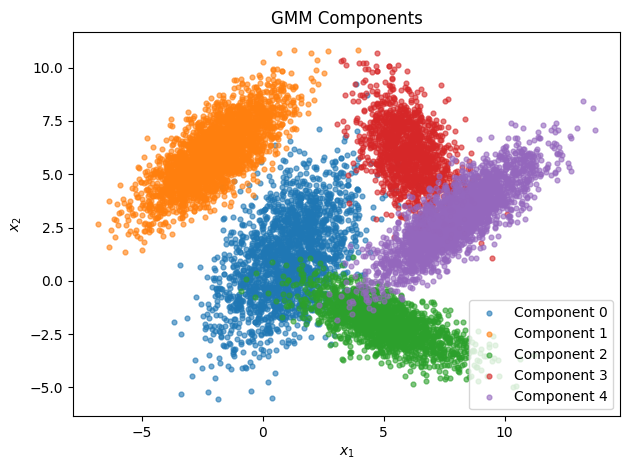

In [517]:
Σ = np.array([Σ1,Σ2,Σ3,Σ4,Σ5])
μ = np.array([μ1,μ2,μ3,μ4,μ5])

X = np.vstack([X1, X2, X3, X4, X5])
y = np.concatenate([y1, y2, y3, y4, y5])

indices = np.random.permutation(X.shape[0])
X = X[indices]
y = y[indices]

X_train=X[:8000]
y_train=y[:8000]

X_test=X[8000:]
y_test=y[8000:]

plot_clusters(X,y,5)

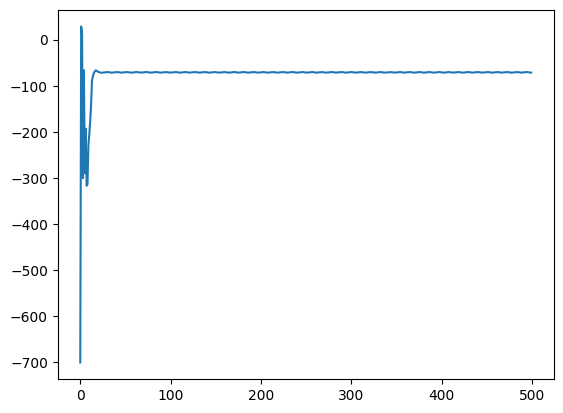

0.7503275346359454


In [542]:
R, W, kappa, m, ν, α, loglikes, elbos= meanfield_vi(X_train,5,mode=0,max_iters=500)
zs = np.argmax(R, axis=1)
plt.plot(loglikes)
plt.show()
print(metrics.adjusted_rand_score(y_train, zs))

In [537]:
scores1 = []
scores2= []
for i in range(0,25):
    R, W, kappa, m, ν, α, loglikes, elbos= meanfield_vi(X_train,5,mode=0,max_iters=400)
    zs = np.argmax(R, axis=1)
    scores1.append(metrics.adjusted_rand_score(y_train, zs))
    scores2.append(elbos[-1])

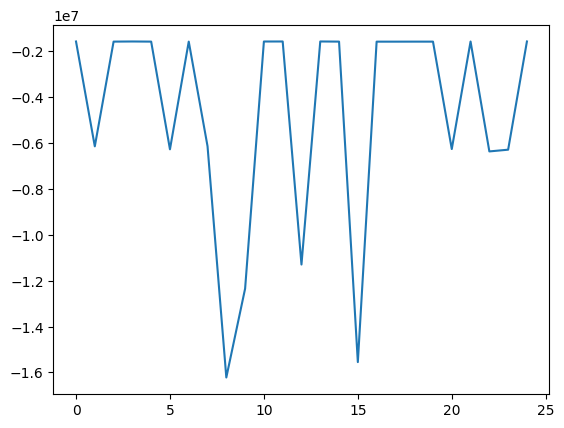

In [538]:
plt.plot(scores2)


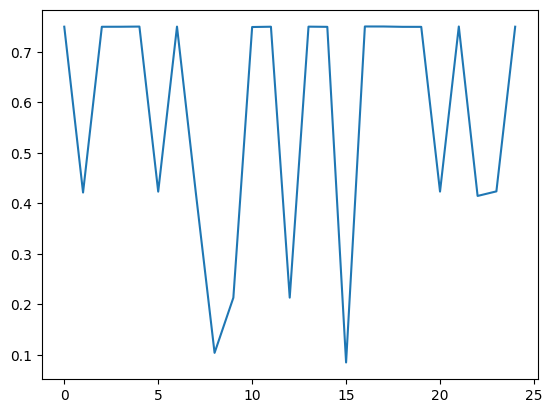

In [539]:
plt.plot(scores1)

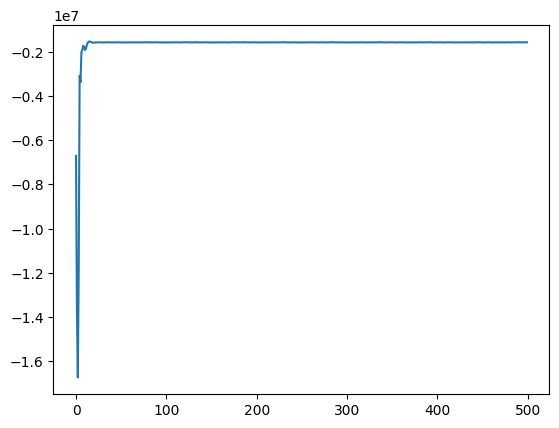

In [522]:
plt.plot(elbos)
plt.show()

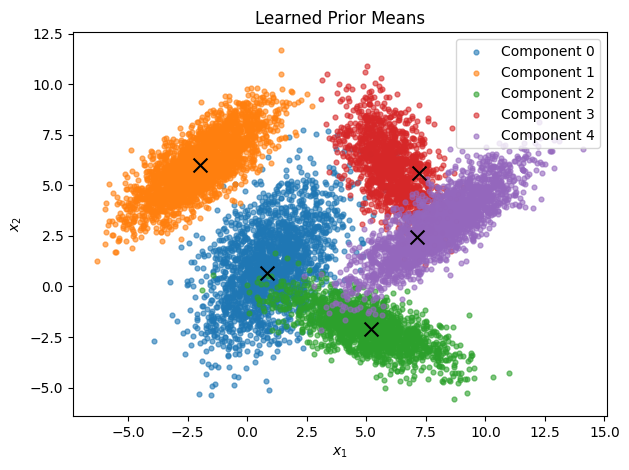

In [248]:
'''  
    Plot learned mean priors (m_k) against ground truth clusters
'''

plot_clusters(X,y,5,m,title="Learned Prior Means")